In [1]:
import os
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras import backend as K
import keras
from numpy import array
from numpy import hstack
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM,Bidirectional
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_path = "/content/drive/MyDrive/Timeseries_test/big_alldata.csv"
df_use = pd.read_csv(data_path)

In [5]:
df_use.columns

Index(['0', 'PM_Routine', 'Routine_Routine', 'General_Routine',
       'OVERHAUL_Routine', 'PdM_Routine', 'CFT_Routine', 'CM_Non-Routine',
       'REC_Non-Routine', 'MoD_Non-Routine', 'PM_Routine_WORK_NOT_DONE',
       'Routine_Routine_WORK_NOT_DONE', 'General_Routine_WORK_NOT_DONE',
       'OVERHAUL_Routine_WORK_NOT_DONE', 'PdM_Routine_WORK_NOT_DONE',
       'CFT_Routine_WORK_NOT_DONE', 'CM_Non-Routine_WORK_NOT_DONE',
       'REC_Non-Routine_WORK_NOT_DONE', 'MoD_Non-Routine_WORK_NOT_DONE',
       'All_Non-Routine_WORK_NOT_DONE', 'PM_Routine_WORK_DONE',
       'Routine_Routine_WORK_DONE', 'General_Routine_WORK_DONE',
       'OVERHAUL_Routine_WORK_DONE', 'PdM_Routine_WORK_DONE',
       'CFT_Routine_WORK_DONE', 'CM_Non-Routine_WORK_DONE',
       'REC_Non-Routine_WORK_DONE', 'MoD_Non-Routine_WORK_DONE',
       'All_Non-Routine_WORK_DONE', 'PM_Routine_DAY_NOT_DONE',
       'Routine_Routine_DAY_NOT_DONE', 'General_Routine_DAY_NOT_DONE',
       'OVERHAUL_Routine_DAY_NOT_DONE', 'PdM_Routine_D

In [6]:
df_use['All_Non-Routine'] = df_use['CM_Non-Routine'] + df_use['REC_Non-Routine'] + df_use['MoD_Non-Routine']

In [7]:
df_use['All_Non-Routine_DAY_DONE'] = df_use['CM_Non-Routine_DAY_DONE'] + df_use['REC_Non-Routine_DAY_DONE'] + df_use['MoD_Non-Routine_DAY_DONE']

In [8]:
def get_data(df_use):
  df_use = df_use.rename(columns = {'0':'Date'})
  col = ['Date','PM_Routine','General_Routine','All_Non-Routine']
  extension = ['_WORK_NOT_DONE','_WORK_DONE','_DAY_NOT_DONE','_DAY_DONE']

  col_ex = []
  for e in extension:
      col_ex.append(col[3] + e)
  col += col_ex
  df = df_use[col]
  df['Date']= pd.to_datetime(df['Date'])
  # df = df[(df['Date'] <= '2021-12-12') & (df['Date'] >= '2017-07-01')]
  df = df.reset_index(drop=True)
  time = df.iloc[:,0]
  df = df.iloc[:,1:]
  return time, df

In [9]:
time_df,df = get_data(df_use)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [10]:
df

,PM_Routine,General_Routine,All_Non-Routine,All_Non-Routine_WORK_NOT_DONE,All_Non-Routine_WORK_DONE,All_Non-Routine_DAY_NOT_DONE,All_Non-Routine_DAY_DONE
0,0.202313,0.000000,0.000000,0.000000,0.0,230.0,0.0
1,4.957640,0.000000,0.000000,0.000000,0.0,229.0,1.0
2,4.957640,0.000000,0.000000,0.000000,0.0,228.0,2.0
3,4.979667,0.000000,0.000000,0.000000,0.0,227.0,3.0
4,4.979667,0.000000,2.142857,69.857143,0.0,373.0,4.0
...,...,...,...,...,...,...,...
2933,20.000000,15.086207,0.000000,0.000000,0.0,0.0,0.0
2934,41.000000,15.086207,0.000000,0.000000,0.0,0.0,0.0
2935,20.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2936,20.000000,21.000000,1.000000,0.000000,0.0,0.0,0.0


In [11]:
df_all = df["All_Non-Routine"].to_list()

In [12]:
df = df[:-30]

In [13]:
df["All_Non-Routine"] = df_all[30:]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [14]:
n = len(df)
x_train = df[0:int(n*0.7)]
x_valid = df[int(n*0.7):int(n*0.9)]
x_test = df[int(n*0.9):]
time_train = time_df[0:int(n*0.7)]
time_valid = time_df[int(n*0.7):int(n*0.9)]
time_predict = time_df[int(n*0.9):]

mean = x_train.mean()
std = x_train.std()
x_train = (x_train - mean)/std
x_valid = (x_valid - mean)/std
x_test = (x_test - mean)/std

In [ ]:
print(n)

2908


In [15]:
x_train.columns

Index(['PM_Routine', 'General_Routine', 'All_Non-Routine',
       'All_Non-Routine_WORK_NOT_DONE', 'All_Non-Routine_WORK_DONE',
       'All_Non-Routine_DAY_NOT_DONE', 'All_Non-Routine_DAY_DONE'],
      dtype='object')

In [16]:
class WindowGenerator():
    def __init__(self, train_df, val_df, test_df,input_features, 
                 label_features, input_width, label_width, shift=0):
        # Store the raw data.
        # self.train_df = train_df
        # self.val_df = val_df
        # self.test_df = test_df
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        print(self.train_df.columns)

        self.input_features=input_features
        self.label_features=label_features

        self.indices_features = {name: i for i, name in
                            enumerate(self.train_df.columns)}
        # self.indices_features = input_features
        # Work out the label column indices.


        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.total_window_size = input_width + shift + label_width


        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        label_start = input_width + shift
        self.label_slice = slice(label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.label_slice]

    def split_window(self, features):
        # print(features)
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.label_slice, :]
        
        inputs = tf.stack(
            [labels[:, :, self.indices_features[name]] for name in self.input_features],
            axis=-1)
        labels = tf.stack(
            [labels[:, :, self.indices_features[name]] for name in self.label_features],
            axis=-1)
        
        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        return inputs, labels

    def make_dataset(self, dataset ,shuffle=True):
        ds_dataset = None
        # print(len(dataset))
        data = np.array(dataset, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=shuffle,
            batch_size=32)

        ds = ds.map(self.split_window)
        if ds_dataset is None:
            ds_dataset = ds
        else:
            ds_dataset = ds_dataset.concatenate(ds)
    
        return ds_dataset

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df, shuffle=False)

    
        
    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
        # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
        # And cache it for next time
            self._example = result
        return result
    # def __repr__(self):
    #     return '\n'.join([
    #         f'Total window size: {self.total_window_size}',
    #         f'Input indices: {self.input_indices}',
    #         f'Label indices: {self.label_indices}',
    #         f'Label column name(s): {self.label_columns}'])

In [17]:
input_features = x_train.columns.to_list()[:-2]
output_features = [x_train.columns.to_list()[2]]

num_input_features = len(input_features)
num_output_features = len(output_features)

indices_features = {name: i for i,name in enumerate(input_features)}
indices_input_features = {name: i for i,name in enumerate(input_features)}
indices_output_features = {name: i for i,name in enumerate(output_features)}

IN_STEPS = 30
OUT_STEPS = 30

In [18]:
multi_window = WindowGenerator(x_train,x_valid,x_test,
                   input_features=input_features, label_features=output_features, 
                    input_width=IN_STEPS, label_width=OUT_STEPS,shift = 29)

Index(['PM_Routine', 'General_Routine', 'All_Non-Routine',
       'All_Non-Routine_WORK_NOT_DONE', 'All_Non-Routine_WORK_DONE',
       'All_Non-Routine_DAY_NOT_DONE', 'All_Non-Routine_DAY_DONE'],
      dtype='object')


In [19]:
checkpoint_path = "/content/drive/MyDrive/Timeseries_test/model"

In [20]:
print(multi_window.train)

<MapDataset element_spec=(TensorSpec(shape=(None, 30, 5), dtype=tf.float32, name=None), TensorSpec(shape=(None, 30, 1), dtype=tf.float32, name=None))>


In [21]:
print(multi_window.val)

<MapDataset element_spec=(TensorSpec(shape=(None, 30, 5), dtype=tf.float32, name=None), TensorSpec(shape=(None, 30, 1), dtype=tf.float32, name=None))>


In [22]:
print(multi_window.test)

<MapDataset element_spec=(TensorSpec(shape=(None, 30, 5), dtype=tf.float32, name=None), TensorSpec(shape=(None, 30, 1), dtype=tf.float32, name=None))>


In [23]:
MAX_EPOCHS = 200

def compile_and_fit(model, window, model_name, patience=50):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min',
                                                      restore_best_weights=True)
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path + model_name, monitor='val_loss', save_best_only=True, save_feq='epoch')
    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])
    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val, callbacks=[early_stopping,model_checkpoint])
    # history = model.fit(window.train, epochs=MAX_EPOCHS,callbacks=[early_stopping,model_checkpoint])
    return history

**BiLSTM**

In [ ]:
multi_bilstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    Bidirectional(LSTM(200, return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    Bidirectional(LSTM(200, return_sequences=False)),
    tf.keras.layers.Dropout(0.2),
    # Shape => [batch, out_steps*features].
    Dense(200),
    Dense(OUT_STEPS*num_output_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_output_features])
])

In [ ]:
history = compile_and_fit(multi_bilstm_model, multi_window, 'BidirectionalModel')

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

**CUSTOM ACCURACY**

In [24]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Timeseries_test/modelBidirectionalModel')

In [26]:
test = multi_window.test
y_predict = model.predict(test)
model.evaluate(test)

7/7 [==============================] - 2s 10ms/step - loss: 0.0013 - mean_absolute_error: 0.0252


[0.0012945022899657488, 0.025238968431949615]

In [27]:
y_test = []
data = x_test[output_features]
data = np.array(data, dtype=np.float32)
# data = data[7:,:]
data = data[30:,:]
ds = tf.keras.preprocessing.timeseries_dataset_from_array(
                data=data,
                targets=None,
                sequence_length=30,
                sequence_stride=1,
                shuffle=False,
                batch_size=len(data))
for i in ds:
    y_test.append(np.array(i))
y_test = np.concatenate(y_test)

In [ ]:
len(data)

261

In [ ]:
len(y_predict)

203

In [28]:
std = np.array(std)[2]
mean = np.array(mean)[2]

In [ ]:
print(len(y_test))
len(y_predict)

232


203

In [ ]:
y_predict


In [29]:
# y_true and y_predict has been inverted

def custome_accuracy(y_true, y_predict, feature ,bias=0.1,shift =29):
    index_col = indices_output_features[feature]
    y_true = y_true[:,shift,index_col]
    y_predict = y_predict[:,shift,index_col]
    # print(len(y_true))
    return np.mean(np.abs((y_true-y_predict)/y_true)<=bias)

In [30]:
print("{} : {}".format(output_features[0],custome_accuracy(y_test[29:] * std + mean,y_predict * std + mean,output_features[0])))

All_Non-Routine : 0.4876847290640394


In [31]:
print(len(y_test))
print(len(y_predict))

232
203


In [ ]:
y_predict

In [44]:
def create_y_test(y_test):
    construct_y_test = []
    for i in range(len(y_test)):
        construct_y_test.append(y_test[i][0])
    for i in y_test[-1][1:]:
        construct_y_test.append(i)
    return construct_y_test

In [45]:
y_test_ = create_y_test(y_test)
y_predict_ = create_y_test(y_predict)

In [ ]:
y_predict_

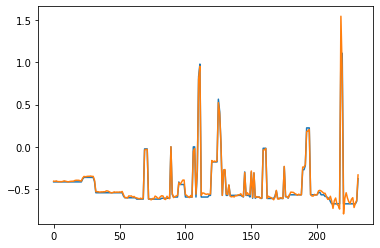

In [50]:
plt.plot(y_test_[29:])
plt.plot(y_predict_)

In [48]:
def custom_accuracy_0(y_true, y_predict ,bias=0.1,shift = 29):
    res = []
    for i in range(len(y_predict)):
      res.append(np.abs((y_true[i + shift]-y_predict[i])/y_true[i + shift]) <= bias)  
    return np.mean(res)

In [49]:
custom_accuracy_0(y_test_,y_predict_)

0.9008620689655172